# Figure. Pluripotency Gene Expression

In [1]:
import copy
import glob

import os
import subprocess

import cdpybio as cpb
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import vcf as pyvcf

import ciepy
import cardipspy as cpy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'pluripotency_gene_expression'
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

Each figure should be able to fit on a single 8.5 x 11 inch page. Please do not send figure panels as individual files. We use three standard widths for figures: 1 column, 85 mm; 1.5 column, 114 mm; and 2 column, 174 mm (the full width of the page). Although your figure size may be reduced in the print journal, please keep these widths in mind. For Previews and other three-column formats, these widths are also applicable, though the width of a single column will be 55 mm.

In [2]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 'wgs_metadata.tsv')
wgs_meta = pd.read_table(fn, index_col=0, squeeze=True)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv')
subject_meta = pd.read_table(fn, index_col=0)

ext_meta = pd.read_table(os.path.join(ciepy.root, 'output', 'input_data', 'GSE73211.tsv'), index_col=0,
                         low_memory=False)

tpm = pd.read_table(os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv'), index_col=0,
                                 low_memory=False)
ext_tpm = pd.read_table(os.path.join(ciepy.root, 'output', 'input_data', 'GSE73211_tpm.tsv'), index_col=0,
                        low_memory=False)

gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)

In [14]:
plur_markers = ['POU5F1', 'SOX2', 'NANOG', 'ZFP42', 'LIN28A']
diff_markers = ['T', 'EOMES', 'SOX17', 'FOXA2', 'GATA4', 'HAND1', 
                'CDX2', 'PAX6', 'SOX1', 'EN1']
def get_gene_id(x):
    return gene_info[gene_info.gene_name == x].index[0]
plur_markers = pd.Series(plur_markers, index=[get_gene_id(x) for x in plur_markers])
diff_markers = pd.Series(diff_markers, index=[get_gene_id(x) for x in diff_markers])

url = 'http://www.nature.com/nbt/journal/v33/n11/extref/nbt.3387-S5.xlsx'
if not os.path.exists(os.path.join(private_outdir, os.path.split(url)[-1])):
    ! wget {url}
    ! mv nbt.3387-S5.xlsx {private_outdir}
scorecard = pd.read_excel(os.path.join(private_outdir, 'nbt.3387-S5.xlsx'))
scorecard = scorecard.drop(scorecard.columns[2:], axis=1)
scorecard = scorecard[scorecard.gene.apply(lambda x: x in gene_info.gene_name.values)]
scorecard.index = [get_gene_id(x) for x in scorecard.gene]
scorecard = scorecard[scorecard['class'].apply(lambda x: x in ['Mesoderm', 'Pluri'])]

tpm_all = pd.concat([tpm, ext_tpm], axis=1)

In [15]:
scorecard['class'].value_counts()

Mesoderm    25
Pluri        9
Name: class, dtype: int64

In [16]:
tdf = np.log10(tpm_all.ix[scorecard.index].T + 1)
tdf = tdf - tdf.mean()
tdf = tdf / tdf.std()

In [17]:
tdf.columns = gene_info.ix[tdf.columns, 'gene_name']
tdf.columns.name = 'Gene name'

In [18]:
ext_meta.cell_type.value_counts()

ESC           35
iPSC          21
Fibroblast    17
Name: cell_type, dtype: int64

In [19]:
colors = dict(zip(['GSE73211 {}'.format(x) for x in list(set(ext_meta.cell_type))], 
                  sns.color_palette('Set2', 7)[3:6]))
colors['iPSC (this study)'] = sns.color_palette('Set2', 7)[2]
colors = pd.Series(colors)
colors = pd.concat([colors, 
                    pd.Series(dict(zip(list(set(scorecard['class'])), sns.color_palette("Set2", 7))))])
colors.index = [x.replace('Pluri', 'Pluripotency') for x in colors.index]

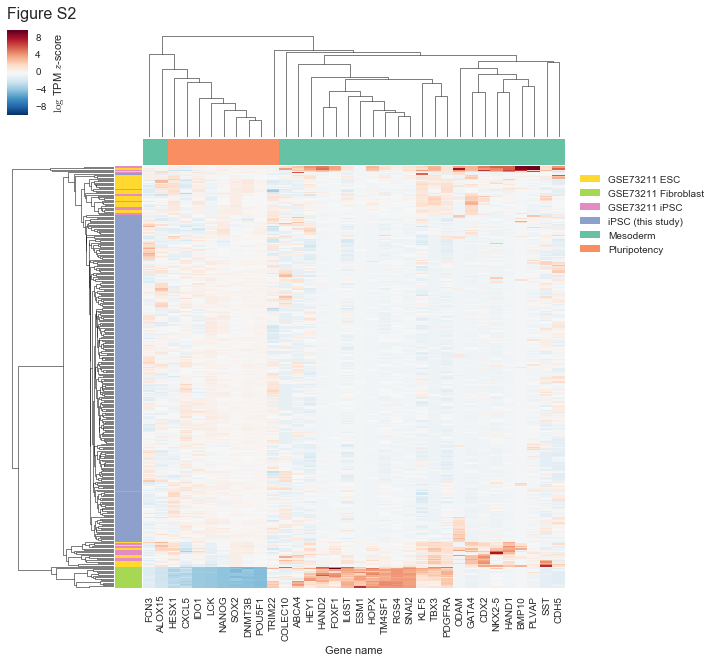

In [20]:
cs = pd.Series(dict(zip(list(set(ext_meta.cell_type)), sns.color_palette('Set2', 7)[3:])))
rc = ([sns.color_palette('Set2', 7)[2]] * tpm.shape[1]) + list(cs[ext_meta.cell_type])
cs = pd.Series(dict(zip(list(set(scorecard['class'])), sns.color_palette("Set2", 7))))
cc = cs[scorecard['class']]

cm = sns.clustermap(tdf, yticklabels=[], col_colors=cc, row_colors=rc);
cm.cax.set_ylabel('$\\log$ TPM $z$-score')
legend_rects = cpb.analysis.make_color_legend_rects(colors)
for i in colors.index:
    cm.ax_heatmap.bar(0, 0, color=colors[i],
                      label=i, linewidth=0)
cm.ax_heatmap.legend(bbox_to_anchor=(1.35, 1));
cm.cax.text(0, 1.1, 'Figure S2', size=16, va='bottom')
cm.savefig(os.path.join(outdir, 'pluri_heatmap.png'), dpi=300)

## POU5F1 targets

In [21]:
url = 'https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2424064/bin/1471-2164-9-269-S21.xls'
targets = pd.read_excel(url, skiprows=2, index_col=0)
targets = targets[targets['Target Pou5f1'] == 1]

In [22]:
targets = targets[[x.upper() in gene_info.gene_name.values for x in targets.index]]
targets.index = [get_gene_id(x.upper()) for x in targets.index]
print('{} POU5F1 targets in both.'.format(targets.shape[0]))

311 POU5F1 targets in both.


In [23]:
fn = os.path.join(ciepy.root, 'private_output', 'eqtl_input', 
                  'filtered_all', '0000.vcf.gz')
vcf_reader = pyvcf.Reader(open(fn), compressed=True)

res_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis', 'eqtls01', 
                                 'gene_results', '*', 'ENS*.tsv'))
res_fns = pd.Series(res_fns,
                    index=[os.path.splitext(os.path.split(x)[1])[0] for x in res_fns])

In [24]:
gene_id = gene_info[gene_info.gene_name == 'POU5F1'].index[0]

In [25]:
exp = tpm_all[rna_meta[rna_meta.in_eqtl].index]
exp.columns = rna_meta.ix[exp.columns, 'wgs_id']

In [26]:
res = ciepy.read_emmax_output(res_fns[gene_id])
res = res.sort_values('PVALUE')
t =  vcf_reader.fetch(res.CHROM.values[0], 
                      res.BEG.values[0], 
                      res.BEG.values[0] + 1)
gts = pd.DataFrame(index=exp.columns)
r = t.next()
gts['Genotype'] = 0
hets = set(exp.columns) & set([s.sample for s in r.get_hets()])
gts.ix[hets, 'Genotype'] = 1
alts = set(exp.columns) & set([s.sample for s in r.get_hom_alts()])
gts.ix[alts, 'Genotype'] = 2

In [27]:
gts.Genotype.value_counts()

1    123
2     80
0     12
Name: Genotype, dtype: int64

In [60]:
cs = pd.Series(dict(zip([0, 1, 2], sns.color_palette('Set2', 7)[3:])))
rc = cs[gts.ix[exp.columns, 'Genotype']]

t = np.log10(exp.ix[targets.index].T + 1)
t = t - t.mean()
t = t / t.std()
t[t > 5] = 5
t[t < -5] = -5

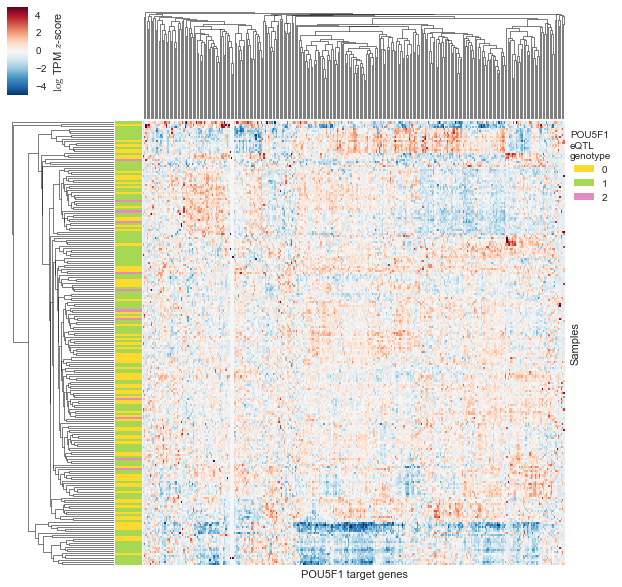

In [62]:
cm = sns.clustermap(t, xticklabels=[], yticklabels=[], row_colors=rc.values)
cm.cax.set_ylabel('$\\log$ TPM $z$-score')
cm.ax_heatmap.set_ylabel('Samples')
cm.ax_heatmap.set_xlabel('POU5F1 target genes')
legend_rects = cpb.analysis.make_color_legend_rects(cs)
for i in cs.index:
    cm.ax_heatmap.bar(0, 0, color=colors[i],
                      label=i, linewidth=0)
cm.ax_heatmap.legend(bbox_to_anchor=(1.13, 1), title='POU5F1\neQTL\ngenotype');
cm.savefig(os.path.join(outdir, 'pou5f1_heatmap.png'), dpi=300);

In [29]:
tsvd = cpb.analysis.SVD(t.T, mean_center=False)

/frazer01/home/cdeboever/software/anaconda/envs/cie/lib/python2.7/site-packages/matplotlib/axes/_axes.py:492: UserWarning: You have mixed positional and keyword arguments, some input will be discarded.
  warnings.warn("You have mixed positional and keyword "


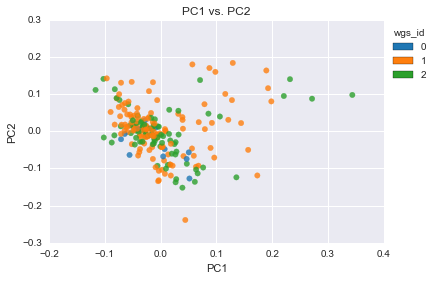

In [30]:
tsvd.plot_pc_scatter('PC1', 'PC2', color=gts.Genotype);

In [31]:
res = tsvd.pc_anova(gts, num_pc=10)
res.ix[:, 'Genotype', :]

,fvalue,pvalue
PC1,0.308540,0.734848
PC2,2.226984,0.110370
PC3,0.324179,0.723478
PC4,1.039474,0.355436
PC5,2.887649,0.057901
PC6,0.569346,0.566758
PC7,0.076764,0.926134
PC8,0.112368,0.893769
PC9,0.476370,0.621697
PC10,1.345919,0.262515


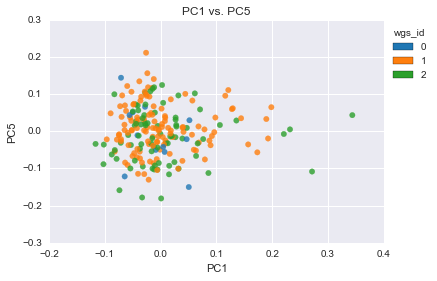

In [32]:
tsvd.plot_pc_scatter('PC1', 'PC5', color=gts.Genotype);

In [33]:
texp = exp[(exp > 2).sum(axis=1) >= 10]
texp = np.log10(texp + 1)
texp = texp.T - texp.mean(axis=1)
texp = (texp / texp.std()).T

In [34]:
texpsvd = cpb.analysis.SVD(texp, mean_center=False)

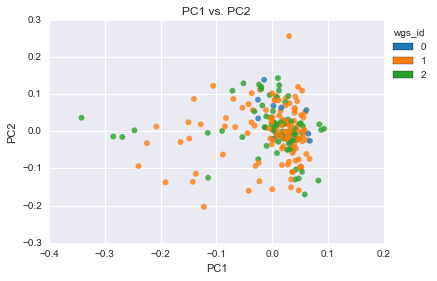

In [35]:
texpsvd.plot_pc_scatter('PC1', 'PC2', color=gts.Genotype);

In [36]:
res = texpsvd.pc_anova(gts, num_pc=10)
res.ix[:, 'Genotype', :]

,fvalue,pvalue
PC1,0.506411,0.603382
PC2,1.781783,0.170849
PC3,1.597442,0.204840
PC4,0.795191,0.452837
PC5,0.480583,0.619095
PC6,0.757960,0.469887
PC7,0.085807,0.917803
PC8,0.294788,0.744994
PC9,1.683569,0.188183
PC10,1.039407,0.355460


In [37]:
texp_sc = texp.ix[scorecard.index].dropna()

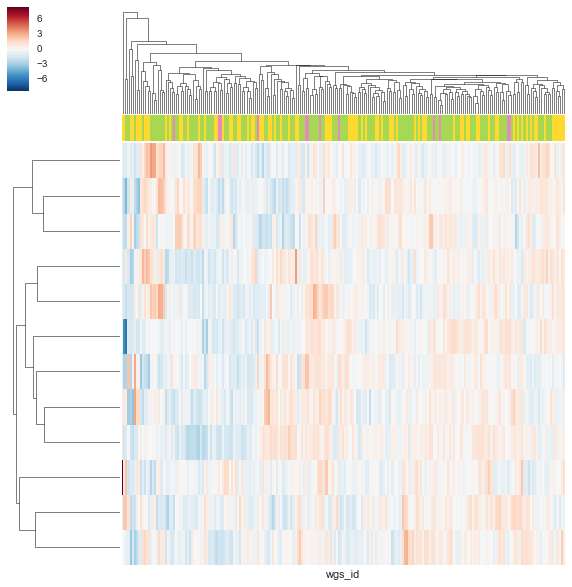

In [38]:
cm = sns.clustermap(texp_sc, xticklabels=[], yticklabels=[], col_colors=cs.ix[gts.ix[texp.columns, 'Genotype']].values);